# Parallel Computing

## General thoughts

Parallel computing is a programming method that **harnesses the power of multiple processors (typically CPU cores) at once**.

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism** (e.g. SIMD)
* **Multi-threading** (shared memory)
* **Multi-processing** (shared system memory)
* **Distributed processing** (typically no shared memory)

**Import note before we start: At the center of an efficient parallel code is a fast serial code!!**

### Why go parallel?

<img src="../imgs/42-years-processor-trend.svg" width=700px>

### When to go parallel?

* If parts of your (optimized!) serial code aren't fast enough.
  * note that parallelization typically increases the code complexity
* If your system has multiple execution units (CPU threads, GPU threads, ...).
  * particularly import on large supercomputers but also already on modern desktop computers and laptops.

### How many CPU threads / cores do I have?

In [1]:
using Hwloc
Hwloc.num_physical_cores()

6

In [2]:
Hwloc.num_virtual_cores()

12

Note that there may be more than one CPU thread per physical CPU core (e.g. hyperthreading).

In [3]:
Sys.CPU_THREADS

12

### How many CPU threads / cores does Hawk have?

[Hawk has about 720k CPU cores!](https://www.hlrs.de/solutions/systems/hpe-apollo-hawk)

Even if you only use a single node you have access to 128 CPU cores (64 per CPU). Hence, if you would use only a single core, the node utilization would be less than 1%.

### Amdahl's law

Naive strong scaling expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by
>$$ F(n) = 1/(1-p + p/n) $$

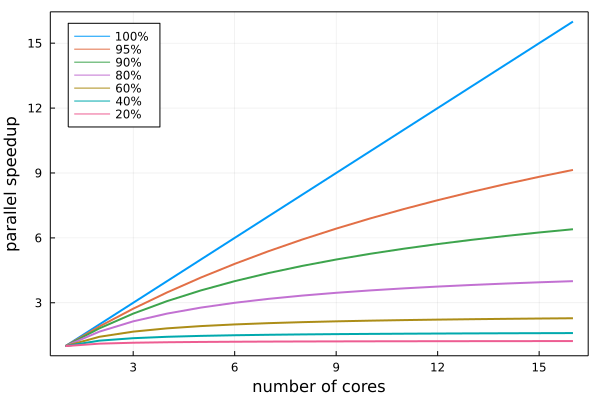

In [4]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

### [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/) in Julia

Julia provides support for all types of parallelism mentioned above (same order)

* `@simd`, [SIMD.jl](https://github.com/eschnett/SIMD.jl), [LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)
* `Threads.@threads`, `Threads.@spawn`, [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl), [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl) ...
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`
* `@spawnat`, `@fetch`, `RemoteChannel`, [DistributedArrays.jl](https://github.com/JuliaParallel/DistributedArrays.jl), [MPI.jl](https://github.com/JuliaParallel/MPI.jl)

With supercomputing in mind, we will start by focusing on multi-process parallelism which allows us to utilize multiple cores on the same or different nodes/machines (distributed computing).

But before we do, it's instructive to take a closer look at **tasks**.

## Tasks

By default, Julia waits for every command to finish ("**blocking**") and run everything sequentially.

**Tasks** are a control flow feature that allows computations to be suspended and resumed in a flexible manner to implement **cooperative multitasking**. (This feature is sometimes called by other names, such as coroutines, green-, or lightweight threads.)

Tasks are managed by Julia and can be run in a **concurrent** fashion.

> **Concurrency** means executing multiple tasks at the same time but not necessarily simultaneously.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes**

## `@async` and `@sync`

We can create and schedule a task for asynchronous execution with the [`@async` macro](https://docs.julialang.org/en/v1/base/parallel/#Base.@async).

What this means is that for whatever falls into its scope, Julia will start a task to then proceed to whatever comes next in the script without waiting for the task to complete ("**non-blocking**").

In [5]:
@time sleep(2);

  2.003487 seconds (67 allocations: 1.984 KiB)


In [6]:
@time @async sleep(2)

  0.015796 seconds (347 allocations: 18.117 KiB, 51.79% compilation time)


Task (runnable) @0x000000011a56f340

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the partner macro `@sync` to synchronize, that is wait for all encapsulated tasks. (see `?@sync`). 

In [7]:
@time @sync @async sleep(2)

  2.029644 seconds (797 allocations: 47.032 KiB, 1.35% compilation time)


Task (done) @0x000000011a709cf0

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether. A better example is the following.

In [8]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.009682 seconds (1.03 k allocations: 62.520 KiB, 0.42% compilation time)


Task (done) @0x000000011a70a0e0

In [9]:
A = rand(1000,1000)
B = rand(1000,1000)

t = @async A * B

Task (done) @0x00000001505d2230

In [10]:
t

Task (done) @0x00000001505d2230

In [11]:
wait(t)

In [12]:
fetch(t)

1000×1000 Matrix{Float64}:
 248.432  243.528  242.934  239.35   …  242.133  234.995  243.539  252.395
 248.762  248.585  244.347  240.124     245.132  237.072  242.023  255.842
 262.268  256.173  262.011  245.382     255.547  245.275  260.271  264.437
 249.465  250.989  245.266  236.232     245.182  239.564  245.432  251.666
 247.437  240.5    239.174  235.011     245.043  233.134  236.739  248.978
 262.772  258.312  256.383  248.114  …  251.131  247.564  258.51   266.421
 248.533  251.452  247.39   235.977     244.749  239.642  237.323  247.171
 251.194  252.422  253.407  238.491     245.319  238.424  245.839  253.074
 251.289  241.052  247.694  237.695     237.02   233.583  239.539  243.19
 257.772  257.217  257.268  244.271     253.3    239.264  250.561  255.407
 254.54   253.279  247.673  241.259  …  247.638  242.99   248.76   256.354
 243.277  242.987  245.515  235.4       244.736  233.432  235.761  248.238
 258.684  256.63   250.042  245.131     253.862  241.992  251.794  262.179